In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

import keras

%matplotlib inline

In [8]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")

In [9]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [10]:
do18 = []
precip = []
temp = []
for i in range(len(t)):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])

In [ ]:
def divide_data(temp: pd.DataFrame, precip: pd.DataFrame, do18: pd.DataFrame, train=0.9, random=True):
    
    if random:
        random_idx = np.random.permutation(do18.index.values)
    
        temp = temp.reindex(random_idx)
        precip = precip.reindex(random_idx)
        do18 = do18.reindex(random_idx)
    
    #divide training and test data
    do18_train = do18[:int(np.floor(train*len(do18)))].reset_index(drop=True)
    do18_test = do18[int(np.floor(train*len(do18))):].reset_index(drop=True)

    temp_train = temp[:int(np.floor(train*len(temp)))].reset_index(drop=True)
    temp_test = temp[int(np.floor(train*len(temp))):].reset_index(drop=True)

    precip_train = precip[:int(np.floor(train*len(precip)))].reset_index(drop=True)
    precip_test = precip[int(np.floor(train*len(precip))):].reset_index(drop=True)
    
    return do18_train, do18_test, temp_train, temp_test, precip_train, precip_test

In [11]:
def ann_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20, train_proportion=0.9, random=True):
    
    do18_train, do18_test, temp_train, temp_test, precip_train, precip_test = divide_data(
        temp, precip, do18, train_proportion, random
    )
    
    #define scalers
    scaler_temp = StandardScaler().fit(temp)
    scaler_precip = StandardScaler().fit(precip)
    scaler_do18 = StandardScaler().fit(do18)
    
    #scale data
    do18_train_scaler = scaler_do18.transform(do18_train)
    do18_test_scaler = scaler_do18.transform(do18_test)

    temp_train_scaler = scaler_temp.transform(temp_train)
    temp_test_scaler = scaler_temp.transform(temp_test)

    precip_train_scaler = scaler_precip.transform(precip_train)
    precip_test_scaler = scaler_precip.transform(precip_test)
    
    #define pcas and fit data
    pca_temp = PCA(n_components=n_temp).fit(np.append(temp_train_scaler, temp_test_scaler, axis=0))
    pca_precip = PCA(n_components=n_precip).fit(np.append(precip_train_scaler, precip_test_scaler, axis=0))
    pca_do18 = PCA(n_components=n_y).fit(np.append(do18_train_scaler, do18_test_scaler, axis=0))
    
    #transform data
    do18_train_pc = pca_do18.transform(do18_train_scaler)
    do18_test_pc = pca_do18.transform(do18_test_scaler)

    temp_train_pc = pca_temp.transform(temp_train_scaler)
    temp_test_pc = pca_temp.transform(temp_test_scaler)

    precip_train_pc = pca_precip.transform(precip_train_scaler)
    precip_test_pc = pca_precip.transform(precip_test_scaler)
    
    
    #####################################################################
    
    
    X_train = np.append(temp_train_pc, precip_train_pc, axis=1)+100
    X_test = np.append(temp_test_pc, precip_test_pc, axis=1)+100

    Y_train = do18_train_pc+100
    Y_test = do18_test_pc+100

    Y = pd.DataFrame(np.append(Y_train, Y_test, axis=0))-100
    
    
    #train model
    
    model = Sequential()
    model.add(Dense(2*(n_temp+n_precip), input_dim=n_temp+n_precip, activation='relu'))
    model.add(Dense(2*(n_temp+n_precip), activation='relu'))
    model.add(Dense(2*(n_temp+n_precip), activation='relu'))
    model.add(Dense(2*(n_temp+n_precip), activation='relu'))
    model.add(Dense(n_y, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer="adam")

    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, verbose=0, batch_size=10)
    
    ####################################################################
    
    #predict test data
    pred_pc = pd.DataFrame(model.predict(X_test)-100)
    pred_norm = pd.DataFrame(pca_do18.inverse_transform(pred_pc))
    pred = pd.DataFrame(scaler_do18.inverse_transform(pred_norm))
    
    
    #return pca and final data
    return pred_pc, pred_norm, pred, do18_test_pc, pd.DataFrame(do18_test_scaler), do18_test

In [12]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = ann_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)

## Sign correlation

In [13]:
def calculate_sign_correlation(pred_norm, do18_test_scaler):
    sign_correlation = np.heaviside(pred_norm*do18_test_scaler, 0) 
    return sign_correlation

In [14]:
sign_correlation_total = calculate_sign_correlation(pred_norm, do18_test_scaler)

In [15]:
for i in range(20):
    print(i)
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = ann_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)
    corr = calculate_sign_correlation(pred_norm, do18_test_scaler)
    sign_correlation_total = sign_correlation_total.append(corr)
sign_correlation_total = sign_correlation_total.reset_index(drop=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
sign_correlation_total = sign_correlation_total.reset_index(drop=True)

In [17]:
sign_correlation_total

,0,1,2,3,4,5,6,7,8,9,...,6806,6807,6808,6809,6810,6811,6812,6813,6814,6815
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2097,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


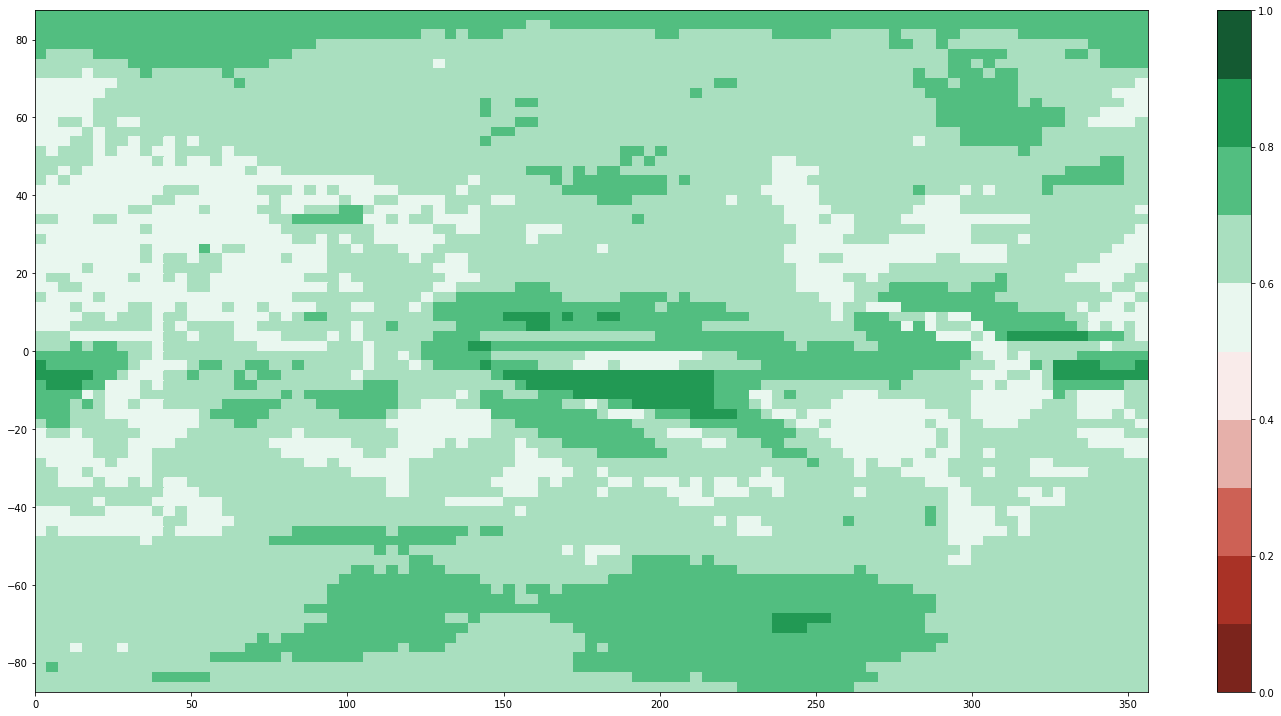

In [18]:
para = sign_correlation_total.mean().values.reshape(71,96)
amin = np.amin(para)
amax = np.amax(para)
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#7b241c", "#a93226", "#cd6155", "#e6b0aa", "#f9ebea", "#e9f7ef", "#a9dfbf", "#52be80", "#229954", "#145a32"]
cmap= matplotlib.colors.ListedColormap(colors)
norm= matplotlib.colors.Normalize(vmin=0,vmax=1)

plt.pcolor(long, lat, para,  cmap=cmap, vmin=0, vmax=1, norm=norm)
plt.tight_layout()
cbar = plt.colorbar()

In [19]:
file = open("sign_correlation_ann_pca.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

124649

In [20]:
pred_list = copy.deepcopy(pred)
test_list = copy.deepcopy(do18_test)

In [21]:
for i in range(15):
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = ann_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)
    pred_list = pred_list.append(pred)
    test_list = test_list.append(do18_test)
pred_list = pred_list.reset_index(drop=True)
test_list = test_list.reset_index(drop=True)

In [23]:
rmse_geolist = []
for pixel in test_list.columns.values:
    rmse_pixel = mean_squared_error(pred_list[pixel].values, test_list[pixel].values, squared=False)
    rmse_geolist.append(rmse_pixel)
df_rmse_geolist = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))

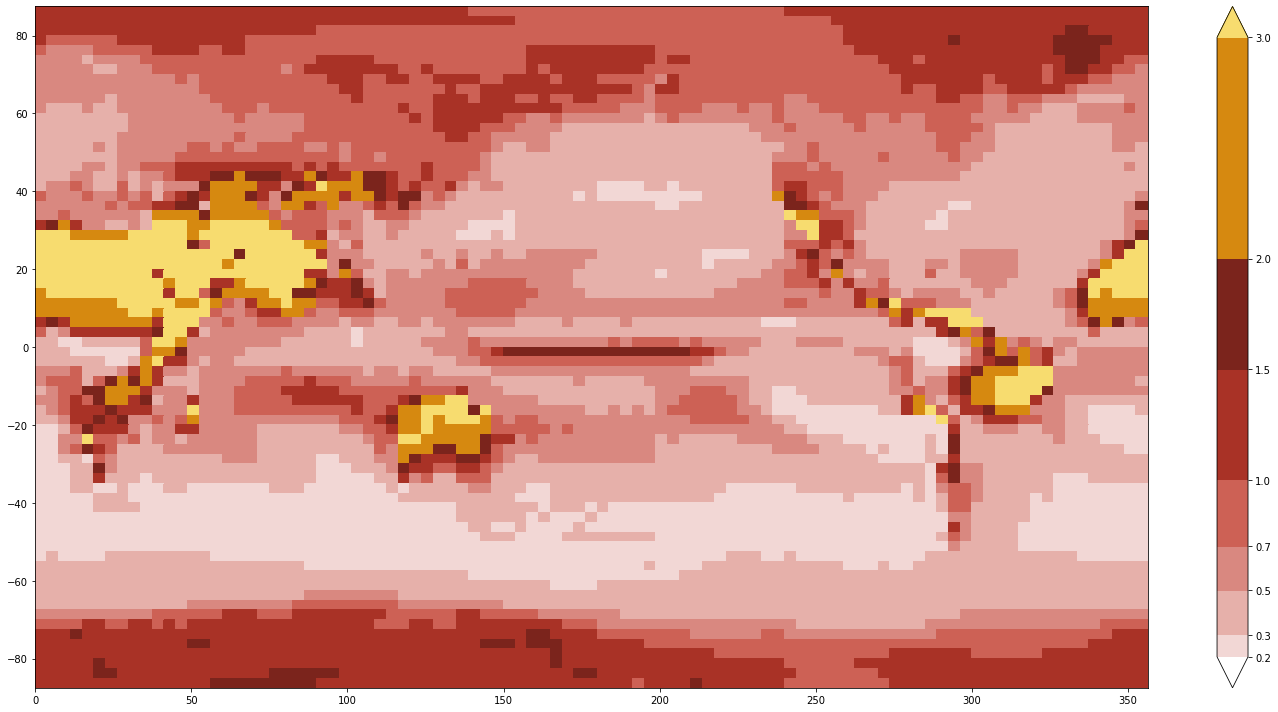

In [24]:
para = df_rmse_geolist.values

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#f2d7d5", "#e6b0aa", "#d98880", "#cd6155", "#a93226", "#7b241c", "#d68910"]
bounds = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_under("#ffffff")
cmap.set_over("#f7dc6f")
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, 
    para, 
    cmap=cmap, 
    vmin=0.1, vmax=3, norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    extend="both", 
    ticks=bounds, 
    spacing='proportional'
)

In [25]:
file = open("rmse_ann_pca.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

129780

In [26]:
std = pd.DataFrame(do18.std().values.reshape(71,96))

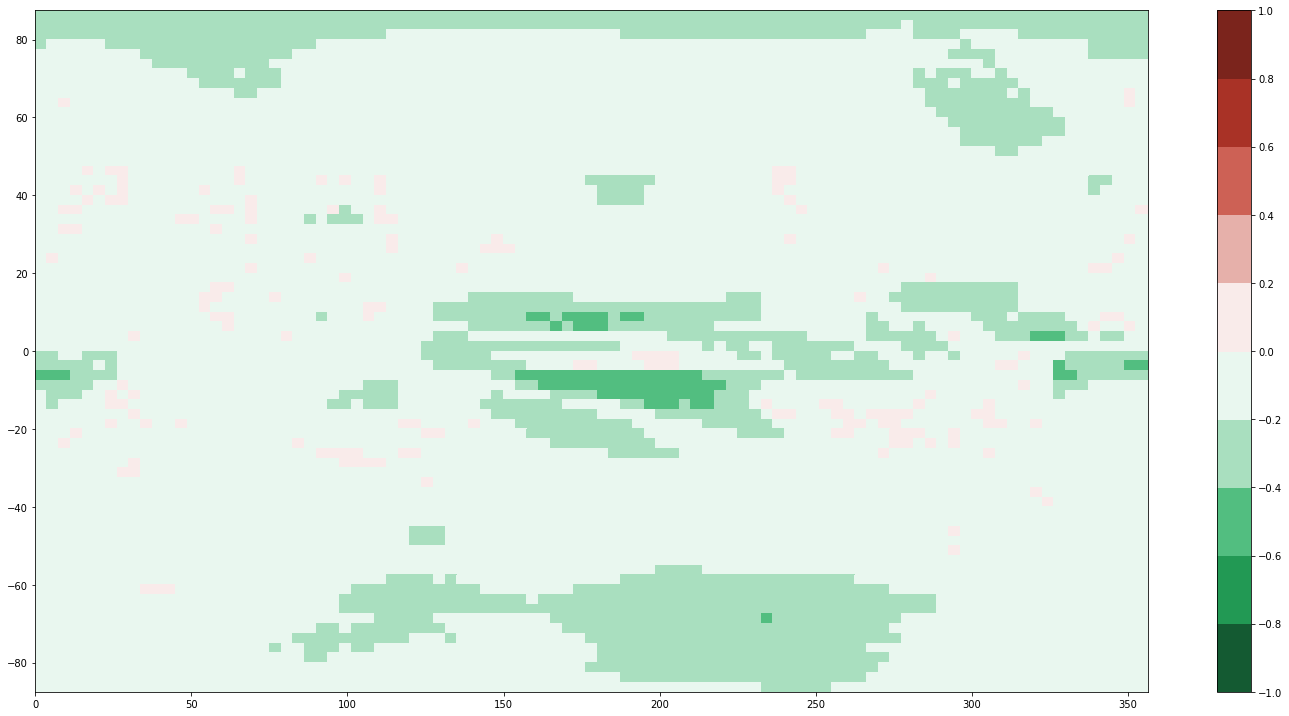

In [27]:
para = df_rmse_geolist/std -1

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#145a32", "#229954", "#52be80", "#a9dfbf",  "#e9f7ef", "#f9ebea", "#e6b0aa", "#cd6155", "#a93226", "#7b241c"]
bounds = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, para, 
    cmap=cmap,
    vmin=-1, vmax=1, 
    norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    ticks=bounds, 
    spacing='proportional'
)

In [28]:
file = open("rmse_norm_ann_pca.txt", "w")
dump = "\n".join((df_rmse_geolist/std -1).values.reshape(71*96).astype(str).tolist())
file.write(dump)

142302